# Státní rozpočet České republiky pro rok 2019: 1505 miliard Kč

Státní rozpočet nezahrnuje zdravotní pojištění, které vybírají přímo zdravotní pojišťovny (v grafech a tabulkách níže je tento výdaj doplněný), rovněž nezahrnuje ani rozpočty místních samospráv (obcí a krajů, ačkoli část peněz je převedena Všeobecnou pokladní správnou do místních rozpočtů).

- HDP v roce 2019: 5 749 mld Kč
- složená daňová kvóta v roce 2019: 34,5 %
- veřejné rozpočty tedy mají k dispozici 1983 mld Kč

Data uvedená níže pokrývají cca 1800 mld Kč, rozdíl tvoří právě rozpočty místních samospráv.

Ministerstvo financí publikuje každý rok **informační leták**:
- [Státní rozpočet 2019 v kostce](https://www.mfcr.cz/assets/cs/media/Informacni-letak_2019_Statni-rozpocet-v-kostce_v1.pdf)
- [Státní rozpočet 2021 v kostce](https://www.mfcr.cz/assets/cs/media/Informacni-letak_2021_Statni-rozpocet-v-kostce_v01.pdf)

**Výdaje pro rok 2019 v .csv**
- [podle kapitol](budget-2019-agg.csv)
- [detailně](budget-2019.csv)

## Příjmy státního rozpočtu

![Příjmy státního rozpočtu](prijmy.jpg)

![Daňová kvóta](danova_kvota.jpg)

![Daňová kvóta v zemích OECD](dane_oecd.jpg)

## Výdaje státního rozpočtu

![Mandatorní a quasi-mandatorní výdaje](mandatorni_vydaje.jpg)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file_defaults()
import seaborn as sns

In [48]:
# Načteme data o státním rozpočtu:
df = pd.read_html('https://www.zakonyprolidi.cz/cs/2018-336')
budget_idx = 4
budget = df[budget_idx].iloc[:-1].copy()
budget['Číslo kapitoly'] = np.int_(budget['Číslo kapitoly'])
budget['Výdaje celkem'] = budget['Výdaje celkem'].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)
budget['Výdaje celkem'] = np.float_(budget['Výdaje celkem'])

# Zdravotní pojištění ale nejde do rozpočtu, ale zdravotním pojišťovnám, které následně hradí lékařskou péči.
# Z pohledu většiny z nás se však neliší od sociálního pojištění či daní, proto náklady pojišťoven na zdravotnictví doplníme do rozpočtu.
# Výsledky zdravotnických účtů podle ČSÚ: https://www.czso.cz/csu/czso/vysledky-zdravotnickych-uctu-cr-m6hwrlzbbw
# Výdaje 309 764 milionů v roce 2019.

budget = budget.append({'Číslo kapitoly': 999, 'Kapitola': 'Zdravotní pojišťovny', 'Výdaje celkem': 309764000000}, ignore_index=True)

# Všeobecná pokladní správa obsahuje nějaké transfery samosprávám, ale část daní jde pravděpodobně do samospráv rovnou.
# Celkové rozpočty samospráv by měly být cca 300 mld. (nebo se jedná o transfery z MŠMT apod?)

### Největší výdaje podle kapitol

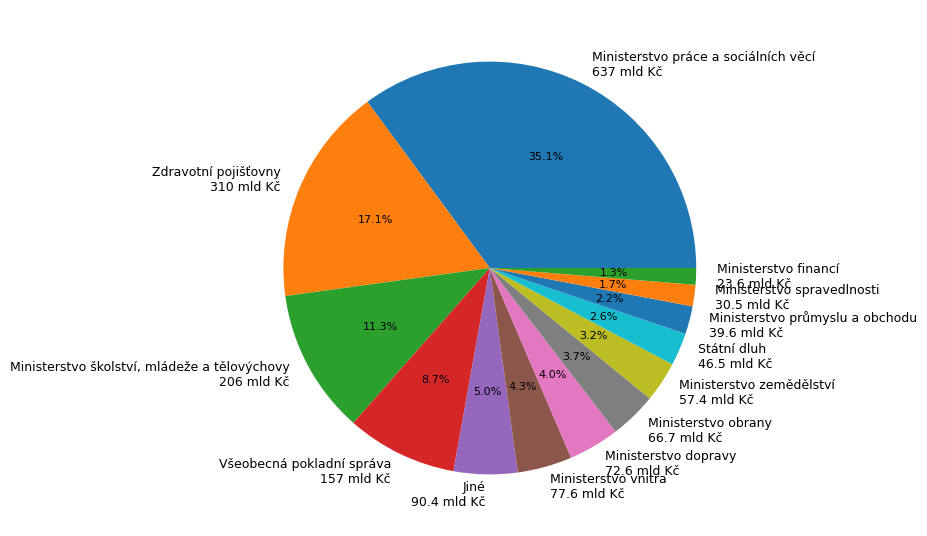

In [65]:
budget['Výdaje (mld Kč)'] = budget['Výdaje celkem'] / 1e9
budget['Oblast'] = np.where(budget['Výdaje (mld Kč)'] > 20, budget['Kapitola'], 'Jiné')
budget_agg = budget.groupby('Oblast')['Výdaje (mld Kč)'].sum()

ba = budget_agg.sort_values(ascending=False).reset_index()
ba['Vydaje'] = ba['Výdaje (mld Kč)']
ba['Label'] = ba.apply(lambda x: f'{x.Oblast}\n{x.Vydaje:.3g} mld Kč', axis=1)
fig, ax = plt.subplots()
ax.pie(ba['Výdaje (mld Kč)'], labels=ba['Label'], autopct='%1.1f%%')
None

In [73]:
kdf = []
i = budget_idx + 1
while i < len(df):
    if df[i].columns[0] == 'KRAJ':
        i = 9999
    else:
        if df[i].columns[0] == 0:
            if df[i].iloc[0][0] == 'Souhrnné ukazatele':
                df[i].columns = df[i].iloc[0]
                kdf.append(df[i].iloc[1:].reset_index(drop=True))
            else:
                df[i].columns = kdf[-1].columns
                kdf[-1] = pd.concat([kdf[-1], df[i]])
        else:
            kdf.append(df[i])        
    i = i + 1        
    
chapters = []
for i, row in budget.iterrows():
    if row['Číslo kapitoly'] < 999:
        foo = kdf[i].copy()
        foo.columns = ['Souhrnné ukazatele', 'Výdaj', 'Částka']
        vydaje_start = foo[foo['Souhrnné ukazatele'] == 'Specifické ukazatele - výdaje'].index[0]
        vydaje_end_df = foo[foo['Souhrnné ukazatele'] == 'Průřezové ukazatele']
        if len(vydaje_end_df):
            kap = foo.iloc[vydaje_start + 1:vydaje_end_df.index[0]][['Výdaj', 'Částka']]
        else:
            kap = foo.iloc[vydaje_start + 1:][['Výdaj', 'Částka']]
        kap['Číslo kapitoly'] = row['Číslo kapitoly']
        kap['Kapitola'] = row['Kapitola']

        kap['Částka'] = kap['Částka'].apply(lambda x: x.replace(' ', '').replace('I', '1') if isinstance(x, str) else x)
        kap['Částka'] = np.float_(kap['Částka'])
        kap = kap[['Číslo kapitoly', 'Kapitola', 'Výdaj', 'Částka']]
        chapters.append(kap)
    else:
        chapters.append(pd.DataFrame({'Číslo kapitoly': [row['Číslo kapitoly']], 'Kapitola': [row['Kapitola']], 'Výdaj': [row['Kapitola']], 'Částka': [row['Výdaje celkem']]}))
    
chapters = pd.concat(chapters).reset_index(drop=True)

In [74]:
chapters = chapters[chapters['Výdaj'].str[0].str.isupper()].copy()
chapters.to_csv('/mnt/d/projects/fakta-o-klimatu/presentations/ekonomicke-okenko/budget-2019.csv', index=False)
chapters_agg = chapters.groupby(['Číslo kapitoly', 'Kapitola'])['Částka'].sum().reset_index()
chapters_agg.to_csv('/mnt/d/projects/fakta-o-klimatu/presentations/ekonomicke-okenko/budget-2019-agg.csv', index=False)

### Výdaje jednotlivých kapitol

In [75]:
chapters_agg['Částka (mld Kč)'] = chapters_agg['Částka'] / 1e9
chapters_agg = chapters_agg.drop(columns=['Částka'])
chapters_agg

,Číslo kapitoly,Kapitola,Částka (mld Kč)
0,301,Kancelář prezidenta republiky,0.405365
1,302,Poslanecká sněmovna Parlamentu,1.332355
2,303,Senát Parlamentu,0.605344
3,304,Úřad vlády České republiky,1.088157
4,305,Bezpečnostní informační služba,2.076974
5,306,Ministerstvo zahraničních věcí,8.127006
6,307,Ministerstvo obrany,66.734801
7,308,Národní bezpečnostní úřad,0.301508
8,309,Kancelář veřejného ochránce práv,0.158932
9,312,Ministerstvo financí,23.617964


### Výdaje detailně

In [76]:
pd.set_option('display.max_rows', 150)
chapters_mld = chapters.copy()
chapters_mld['Částka (mld Kč)'] = chapters_mld['Částka'] / 1e9
chapters_mld = chapters_mld.drop(columns=['Částka']).reset_index(drop=True)
chapters_mld

,Číslo kapitoly,Kapitola,Výdaj,Částka (mld Kč)
0,301,Kancelář prezidenta republiky,Výdaje vlastního úřadu Kanceláře prezidenta re...,0.130864
1,301,Kancelář prezidenta republiky,Celkové výdaje na areál Pražského hradu a zámk...,0.242226
2,301,Kancelář prezidenta republiky,Celkové výdaje na lesní hospodářství,0.032275
3,302,Poslanecká sněmovna Parlamentu,Výdaje Poslanecké sněmovny Parlamentu ČR,1.332355
4,303,Senát Parlamentu,Výdaje Senátu Parlamentu ČR,0.605344
5,304,Úřad vlády České republiky,Výdaje na zabezpečení úkolů Úřadu vlády ČR,1.088157
6,305,Bezpečnostní informační služba,Výdaje na zabezpečení plnění úkolů Bezpečnostn...,2.076974
7,306,Ministerstvo zahraničních věcí,Výdaje na plnění úkolů Ministerstva zahraniční...,8.127006
8,307,Ministerstvo obrany,Zajištění obrany ČR silami Armády ČR,43.054700
9,307,Ministerstvo obrany,Vytváření a rozvoj systému obrany státu,11.838992
